


# **Generative Adversarial Networks (GANs) in Keras - Deep Convolutional GANs or DCGAN with MNIST**

---


In this lesson, we first learn to implement a basic **Generative Adversarial Networks (GANs) or DCGAN** with Keras using the MNIST dataset.

In this tutorial we demonstrate the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to [cyclegan](cyclegan.ipynb)). This approach is much faster (up to 1000x).

1. Setup & load and prepare the dataset
2. Load and prepare the dataset
3. Define our Generator Model
4. Define our Discriminator Model
5. Define the loss and optimizers
6. Define the training loop
7. Training the model



## **A Recap on GANs**
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are a really cool domain of Deep Learning where we produce new data that plausibly came from the dataset we train on.

To do this we use a *generator* network that learns to create images that look real, while a *discriminator* network learns to tell real images apart from fakes.

As training progresses the *generator* becomes better at making images that look real, while simultaenously the *discriminator* becomes better at telling them apart.

The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes. In this tutorial we demonstrate this process on the MNIST dataset.


![A second diagram of a generator and discriminator](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202021-06-03%20at%209.54.37%402x.png)



In [1]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-575efptx
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-575efptx
  Resolved https://github.com/tensorflow/docs to commit a8576cef38b7182e6228d7aafca8ef51754ab9e8
  Preparing metadata (setup.py) ... done


In [2]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython import display
from tqdm import tqdm
from tensorflow.keras import layers
import scipy
from scipy.linalg import sqrtm
%matplotlib inline

## **Load and prepare the dataset**

We will train our GAN using the MNIST dataset, in the end we want our generator to be able to generate handwritten digits resembling those of the MNIST dataset.

In [3]:
# Download MNIST
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape and Normalize
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Set Batch and Buffer Size
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

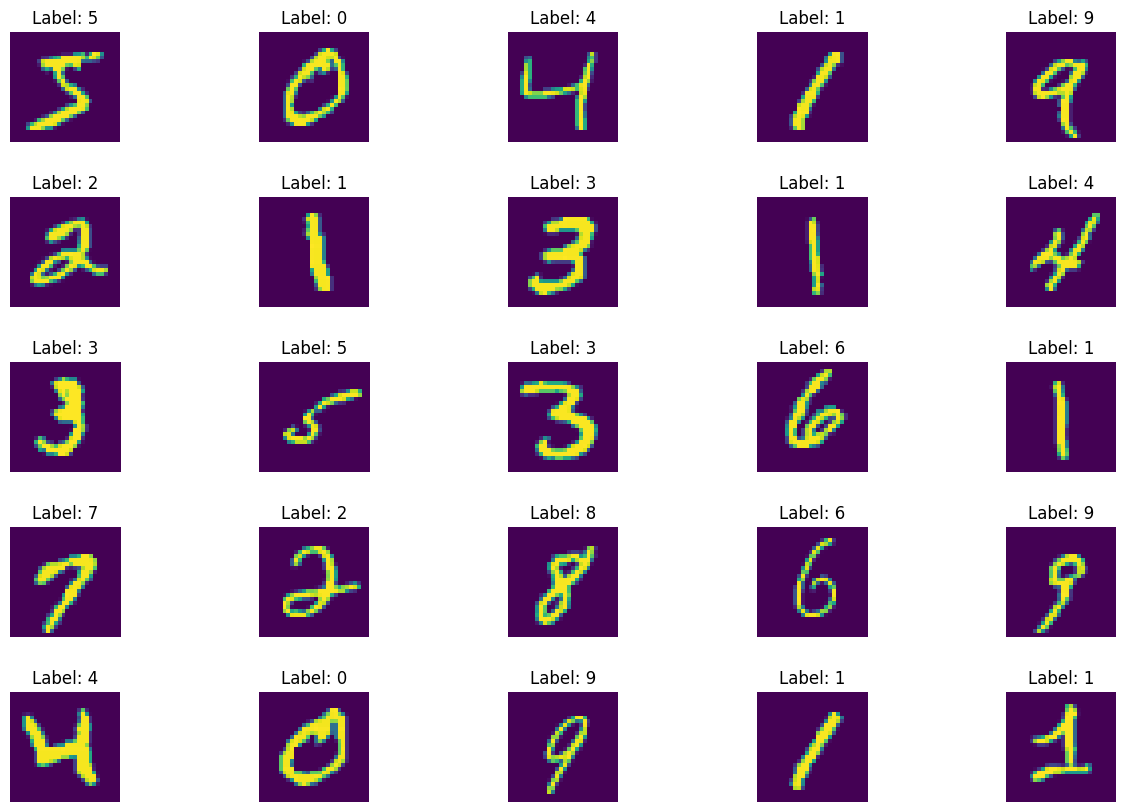

In [4]:
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
axes = axes.ravel()
for i in range(25):

    axes[i].imshow(train_images[i])
    axes[i].set_title(f'Label: {train_labels[i]}')
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## **Define our Generator Model**

* Both the generator and discriminator are defined using the Keras Sequential API.

* The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.


In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

### Now let's see how good our untrained generator is at making a 28x28 grayscale image (like MNIST).

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


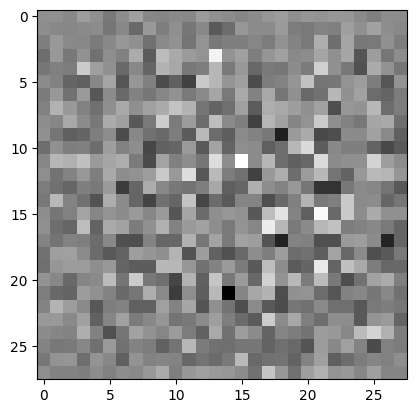

In [6]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

# **Define our Discriminator Model**

**The discriminator is simply CNN-based image classifier.**

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Note the output is a single binary node

    return model

In [8]:
discriminator = make_discriminator_model()
# Use the generated image produced by our untrained Generator
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.0014696]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Define the loss and optimizers

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# **Discriminator loss**

* This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# **Generator loss**
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### The discriminator and the generator optimizers are different since you will train two networks separately.

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# **Save checkpoints**
**This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.**

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#  Training parameters

In [14]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# Function to generate and save images

In [15]:
def generate_and_save_images(model, epoch, test_input, show=True, save=True):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    if save:
        plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    if show:
        plt.show()
    plt.close(fig)


# FID calculation (requires InceptionV3)

In [16]:
def calculate_fid(real_images, generated_images):
    from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Resize and convert to RGB
    real_images = tf.image.resize(real_images, [299, 299])
    real_images = tf.image.grayscale_to_rgb(real_images)
    generated_images = tf.image.resize(generated_images, [299, 299])
    generated_images = tf.image.grayscale_to_rgb(generated_images)

    # Preprocess for InceptionV3
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # Get activations
    act1 = model.predict(real_images)
    act2 = model.predict(generated_images)

    # Calculate mean and covariance
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    # Calculate FID
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid


# Training step

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, real_output, fake_output

# Training loop with tqdm and metrics

Epoch 1/20: 100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step

Epoch 1:
  Generator Loss: 0.8646
  Discriminator Loss: 0.9130
  Discriminator Accuracy: 0.7955
  FID Score: 36.2540
  Time: 78.98 sec


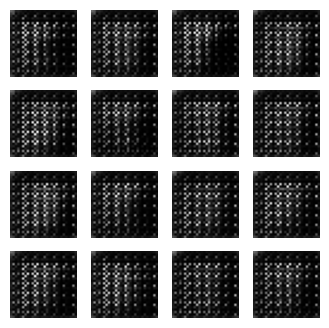

Epoch 2/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step

Epoch 2:
  Generator Loss: 0.8012
  Discriminator Loss: 1.3029
  Discriminator Accuracy: 0.6311
  FID Score: 17.1580
  Time: 54.79 sec


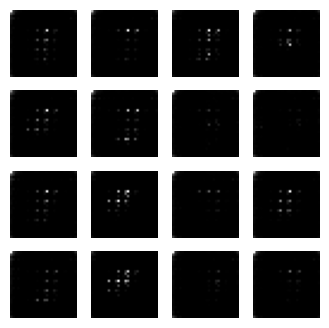

Epoch 3/20: 100%|██████████| 235/235 [00:13<00:00, 18.01it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step

Epoch 3:
  Generator Loss: 0.8407
  Discriminator Loss: 1.2440
  Discriminator Accuracy: 0.6657
  FID Score: 6.3339
  Time: 40.77 sec


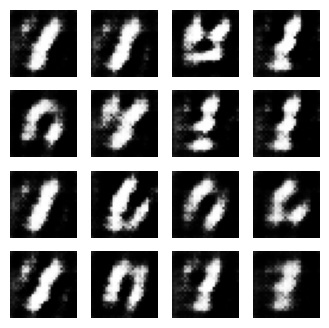

Epoch 4/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step

Epoch 4:
  Generator Loss: 0.8879
  Discriminator Loss: 1.1684
  Discriminator Accuracy: 0.7153
  FID Score: 4.9063
  Time: 53.21 sec


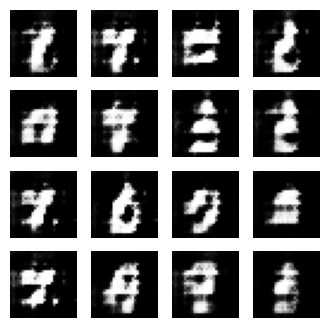

Epoch 5/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step

Epoch 5:
  Generator Loss: 1.0581
  Discriminator Loss: 1.1702
  Discriminator Accuracy: 0.6912
  FID Score: 7.8408
  Time: 49.36 sec


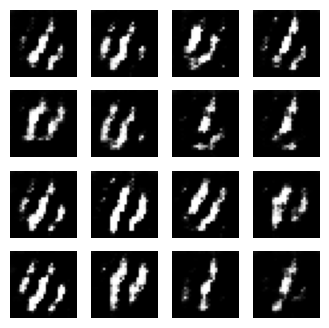

Epoch 6/20: 100%|██████████| 235/235 [00:13<00:00, 17.90it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step

Epoch 6:
  Generator Loss: 0.9200
  Discriminator Loss: 1.2423
  Discriminator Accuracy: 0.6663
  FID Score: 15.4088
  Time: 44.63 sec


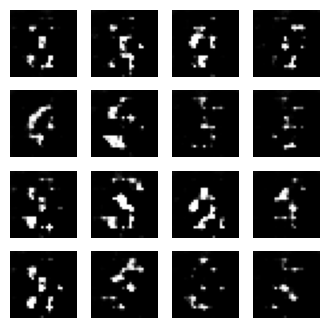

Epoch 7/20: 100%|██████████| 235/235 [00:13<00:00, 17.91it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step

Epoch 7:
  Generator Loss: 0.8180
  Discriminator Loss: 1.3731
  Discriminator Accuracy: 0.5857
  FID Score: 6.2350
  Time: 41.27 sec


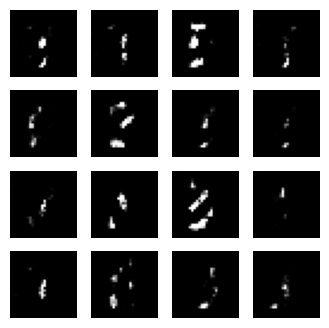

Epoch 8/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step

Epoch 8:
  Generator Loss: 0.8610
  Discriminator Loss: 1.2218
  Discriminator Accuracy: 0.6792
  FID Score: 4.6364
  Time: 53.60 sec


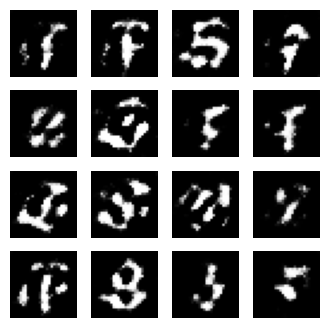

Epoch 9/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step

Epoch 9:
  Generator Loss: 0.8473
  Discriminator Loss: 1.2809
  Discriminator Accuracy: 0.6413
  FID Score: 4.5115
  Time: 51.94 sec


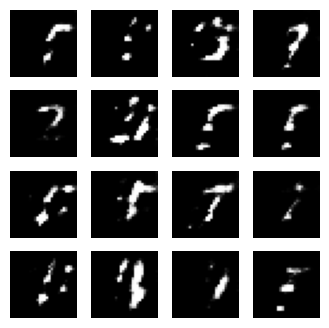

Epoch 10/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 299ms/step

Epoch 10:
  Generator Loss: 1.0014
  Discriminator Loss: 1.1666
  Discriminator Accuracy: 0.7025
  FID Score: 5.7333
  Time: 49.88 sec


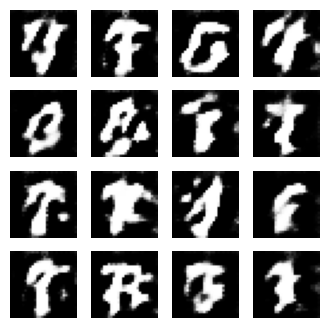

Epoch 11/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step

Epoch 11:
  Generator Loss: 0.9585
  Discriminator Loss: 1.2268
  Discriminator Accuracy: 0.6816
  FID Score: 7.1349
  Time: 49.65 sec


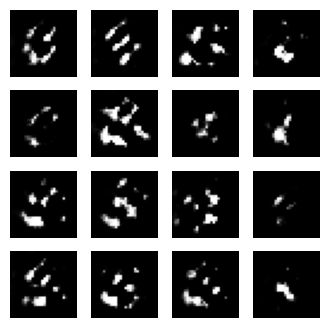

Epoch 12/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step

Epoch 12:
  Generator Loss: 1.0510
  Discriminator Loss: 1.1107
  Discriminator Accuracy: 0.7213
  FID Score: 4.6882
  Time: 54.50 sec


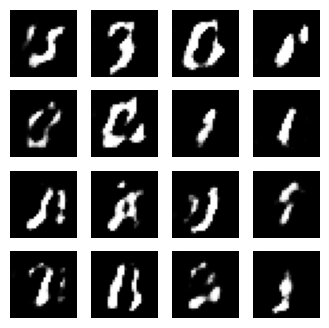

Epoch 13/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step

Epoch 13:
  Generator Loss: 1.0132
  Discriminator Loss: 1.1555
  Discriminator Accuracy: 0.7025
  FID Score: 3.4235
  Time: 50.13 sec


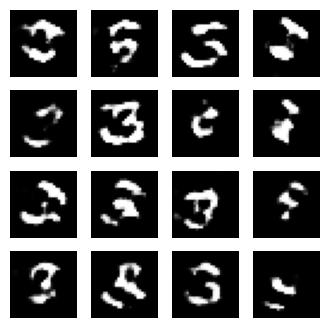

Epoch 14/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step

Epoch 14:
  Generator Loss: 1.0859
  Discriminator Loss: 1.0976
  Discriminator Accuracy: 0.7342
  FID Score: 3.2460
  Time: 52.31 sec


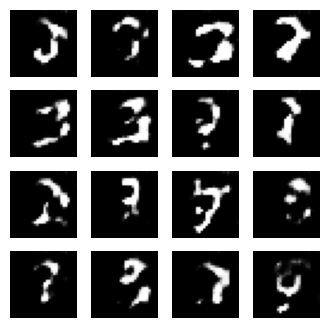

Epoch 15/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step

Epoch 15:
  Generator Loss: 1.1886
  Discriminator Loss: 1.1252
  Discriminator Accuracy: 0.7192
  FID Score: 5.3425
  Time: 49.07 sec


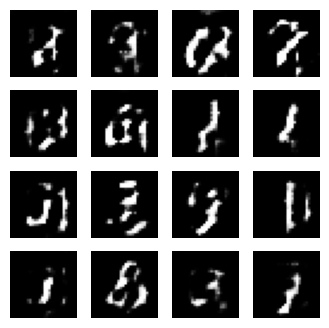

Epoch 16/20: 100%|██████████| 235/235 [00:13<00:00, 17.92it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step

Epoch 16:
  Generator Loss: 1.0731
  Discriminator Loss: 1.1346
  Discriminator Accuracy: 0.7150
  FID Score: 3.8046
  Time: 45.04 sec


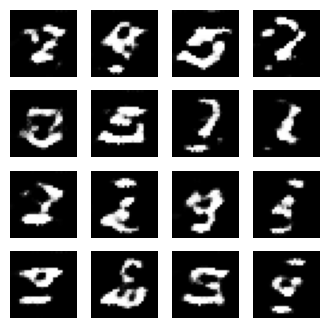

Epoch 17/20: 100%|██████████| 235/235 [00:13<00:00, 17.89it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step

Epoch 17:
  Generator Loss: 1.1558
  Discriminator Loss: 1.0674
  Discriminator Accuracy: 0.7474
  FID Score: 4.1494
  Time: 45.55 sec


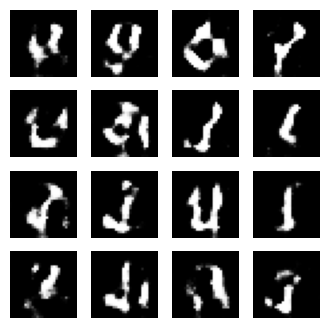

Epoch 18/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step

Epoch 18:
  Generator Loss: 1.1506
  Discriminator Loss: 1.0668
  Discriminator Accuracy: 0.7480
  FID Score: 2.9206
  Time: 53.03 sec


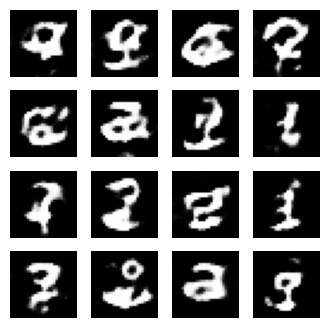

Epoch 19/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step

Epoch 19:
  Generator Loss: 1.1974
  Discriminator Loss: 1.0265
  Discriminator Accuracy: 0.7626
  FID Score: 3.0310
  Time: 53.03 sec


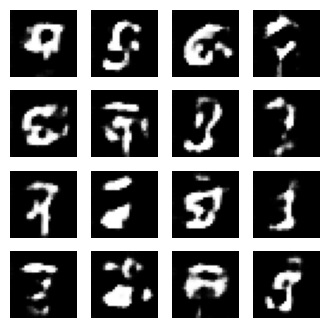

Epoch 20/20: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step

Epoch 20:
  Generator Loss: 1.1317
  Discriminator Loss: 1.0916
  Discriminator Accuracy: 0.7311
  FID Score: 2.3927
  Time: 51.78 sec


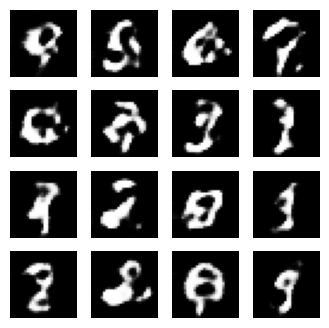

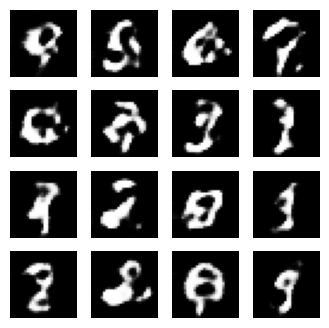

In [18]:
from tqdm import tqdm  # Ensure tqdm is imported

def train(dataset, epochs):
    gen_losses, disc_losses, fid_scores, disc_accuracies = [], [], [], []

    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss, epoch_disc_loss = [], []
        real_correct, fake_correct, total = 0, 0, 0

        # Progress bar for batches
        for image_batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{epochs}"):
            gen_loss, disc_loss, real_output, fake_output = train_step(image_batch)
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)

            # Discriminator accuracy
            real_pred = tf.sigmoid(real_output) > 0.5
            fake_pred = tf.sigmoid(fake_output) <= 0.5
            real_correct += tf.reduce_sum(tf.cast(real_pred, tf.int32))
            fake_correct += tf.reduce_sum(tf.cast(fake_pred, tf.int32))
            total += real_pred.shape[0] * 2

        # Average losses
        avg_gen_loss = np.mean(epoch_gen_loss)
        avg_disc_loss = np.mean(epoch_disc_loss)
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        # Discriminator accuracy
        disc_accuracy = (real_correct + fake_correct) / total
        disc_accuracies.append(disc_accuracy)

        # FID score (calculate every epoch, but can be slow)
        num_fid_samples = 1000
        noise = tf.random.normal([num_fid_samples, noise_dim])
        generated_images = generator(noise, training=False)
        real_images = next(iter(dataset))[:num_fid_samples]
        fid = calculate_fid(real_images, generated_images)
        fid_scores.append(fid)

        # Print metrics
        print(f"\nEpoch {epoch+1}:")
        print(f"  Generator Loss: {avg_gen_loss:.4f}")
        print(f"  Discriminator Loss: {avg_disc_loss:.4f}")
        print(f"  Discriminator Accuracy: {disc_accuracy:.4f}")
        print(f"  FID Score: {fid:.4f}")
        print(f"  Time: {time.time() - start:.2f} sec")

        # Generate and display images (REMOVED: display.clear_output(wait=True))
        generate_and_save_images(generator, epoch + 1, seed, show=True, save=True)

        # Save checkpoint every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Final images (REMOVED: display.clear_output(wait=True))
    generate_and_save_images(generator, epochs, seed, show=True, save=True)

    return gen_losses, disc_losses, fid_scores, disc_accuracies

# Run training
gen_losses, disc_losses, fid_scores, disc_accuracies = train(train_dataset, EPOCHS)

# Plot metrics

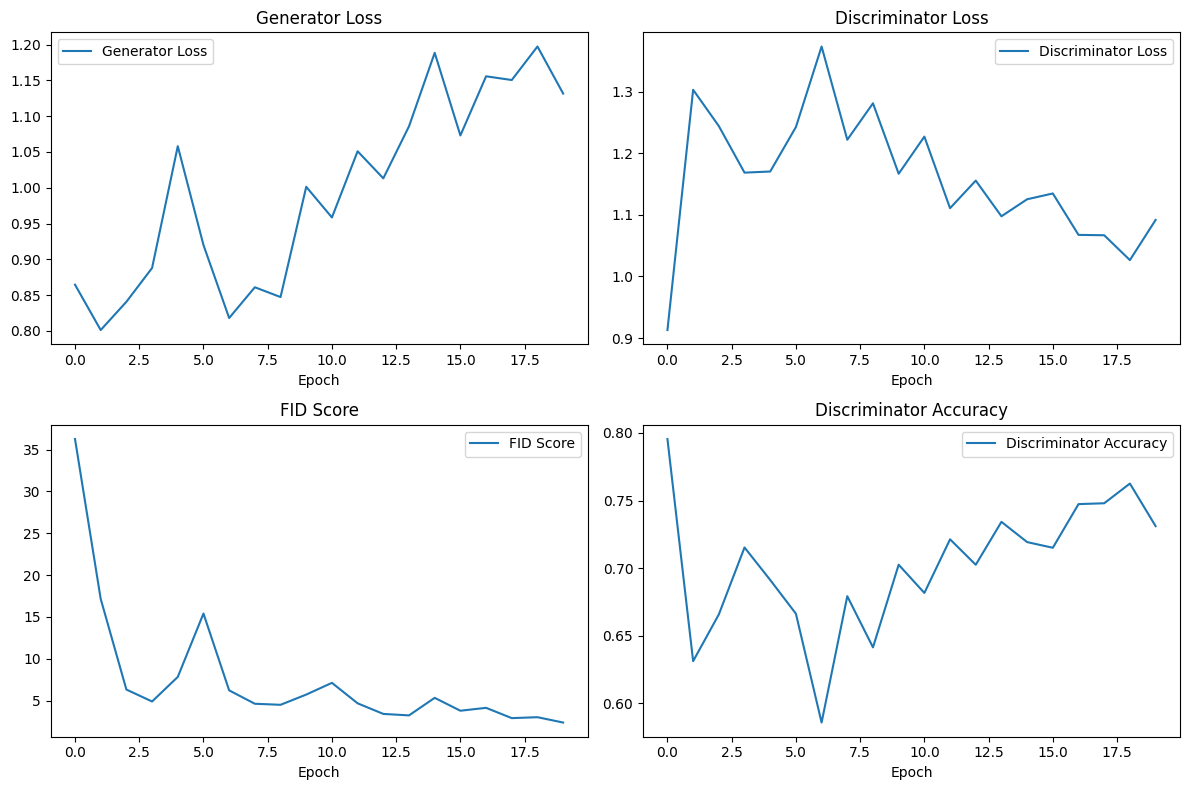

In [19]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(gen_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(disc_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(fid_scores, label='FID Score')
plt.title('FID Score')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(disc_accuracies, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Restore the latest checkpoint.

In [20]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Output - Let's create a GIF

In [21]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

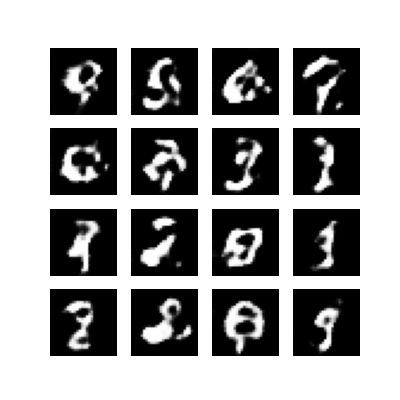

In [22]:
display_image(EPOCHS)

# Use imageio to create an animated gif using the images saved during training.

In [23]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-23-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-23-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



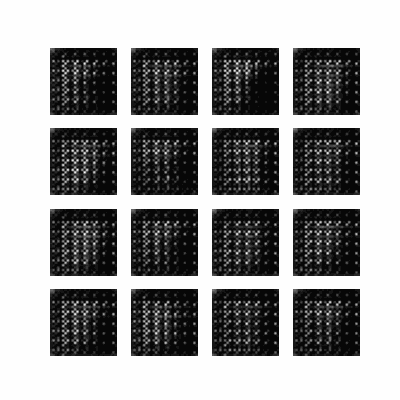

In [25]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)